### Visualizations of MNIST training

In [35]:
import importlib
from jax import jit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

import jaxley as jx
from jaxley_retina.tasks.mnist.image_to_stim import stimulus_from_image
from jaxley_retina.tasks.mnist.simple_data_prep import build_train_loader

In [23]:
# Config file example
model_config = {
    'BC_readouts': True,
    'use_benison': True, # use simpler calcium dynamics from Benison et al. 2001
    'connections': 'local', # connectivity of cones and HCs
    'nHCs': 9,
    'nPRs': 200,
    'n_rad': 50, # number of cones connected to each HC
    'n_readouts': 10,
    'ptc_path': '../../params/cascade/params_3.pkl',
    'ribbon_path': '../../params/ribbon/best_20_params.pkl',
    'model_builder': 'jaxley_retina.tasks.mnist.model'
}
stim_config = {
    'digits': 'all',
    'dt': 0.025, # ms
    'outer_ramp_up': 1000, # ms
    'peak_end': 50, # ms
    'peak_start': 0, # ms
    'var': 'PR_Phototransduction_Stim',
    'stim_max': 40_000, # P*/s, maximum cone input
    't_max': 200, # ms, shorter would be too fast for the glutamate release timescale
    'test_contrast_max': 1.0,
    'test_contrast_min': 0.1,
    'test_lum_max': 0.1, # 0.0 for testing OOD accuracy
    'test_lum_min': 0.0,
    'train_contrast_min': 0.1, # changed when testing for OOD accuracy
    'train_contrast_max': 1.0,
    'train_lum_max': 0.1, # 0.0 for testing OOD accuracy
    'train_lum_min': 0.0
}
train_config = {
    # Parameter initializations and constraint bounds
    'IonotropicSynapse_gS_init': 'normal',
    'IonotropicSynapse_gS_init_mean': 0.01,
    'IonotropicSynapse_gS_init_std': 0.001,
    'IonotropicSynapse_gS_lower': -20,
    'IonotropicSynapse_gS_upper': -3,
    'RibbonHC_gS_init': 'normal',
    'RibbonHC_gS_init_mean': 1.0e-07,
    'RibbonHC_gS_init_std': 1.0e-08,
    'RibbonHC_gS_lower': -25,
    'RibbonHC_gS_upper': -5,
    'RibbonReadout_gS_init': 'normal',
    'RibbonReadout_gS_init_mean': 1.0e-06,
    'RibbonReadout_gS_init_std': 1.0e-07,
    'RibbonReadout_gS_lower': -20,
    'RibbonReadout_gS_upper': -3,
    # Learning schedule specs
    'batch_size': 32,
    'checkpoint_lengths': [20, 20, 20],
    'decay_rate': 0.9,
    'loss_start': 0, # ms
    'max_epochs': 5,
    'seed': 0,
    'start_lr': 0.01,
    'stop_criteria': 0.995,
    'transition_steps': 1000,
}

_ = np.random.seed(train_config['seed'])


In [19]:
# Build the model
model_builder = importlib.import_module(model_config["model_builder"])
network = model_builder.build_mnist_model(model_config)

# Set up the parameter training (according to the model)
network, transform = model_builder.setup_param_training(network, train_config)

Number of newly added trainable parameters: 2000. Total number of trainable parameters: 2000
Number of newly added trainable parameters: 450. Total number of trainable parameters: 2450
Number of newly added trainable parameters: 450. Total number of trainable parameters: 2900


In [25]:
# Record activity of readouts
network.delete_recordings()
readout_inds = network.readout.nodes.global_cell_index.tolist()
network.cell(readout_inds).record("v")

Added 10 recordings. See `.recordings` for details.


In [26]:
# Do the ramp-up for the network and save the states
PR_inds = network.PR.nodes.global_cell_index.tolist()
ramp_up_time = np.arange(0, stim_config["outer_ramp_up"], stim_config["dt"])
ramp_up_stim = np.zeros((len(PR_inds), len(ramp_up_time)))

# Initial parameters
params = network.get_parameters()

data_clamps = network.cell(PR_inds).data_clamp(stim_config["var"], ramp_up_stim, None)
init_soln, init_states = jx.integrate(
    network,
    delta_t=stim_config["dt"],
    data_clamps=data_clamps,
    params=params, 
    return_states=True
)

In [27]:
if isinstance(train_config["checkpoint_lengths"], int):
    assert(train_config["checkpoint_lengths"] > 0), "Checkpoint lengths must be > 0"
    levels = train_config["checkpoint_lengths"]
    num_timesteps = int(stim_config["t_max"] / stim_config["dt"])
    checkpoints = [int(np.ceil(num_timesteps ** (1/levels))) for _ in range(levels)]
else:
    checkpoints = train_config["checkpoint_lengths"]

@jit
def simulate(params, stim):
    data_clamps = network.cell(PR_inds).data_clamp(stim_config["var"], stim, None)
    soln = jx.integrate(
        network, 
        delta_t=stim_config["dt"],
        data_clamps=data_clamps,
        params=params,
        all_states=init_states,
        checkpoint_lengths=checkpoints
    )
    return soln[:, :-1]

In [28]:
# Stimuli prep
network.PR.compute_compartment_centers()
coords = np.vstack((network.PR.nodes.x, network.PR.nodes.y))

In [30]:
# Training loop
ds_train, = build_train_loader(
    train_config["batch_size"], 
    digits=stim_config["digits"],
    contrast_range=(stim_config["train_contrast_min"], stim_config["train_contrast_max"]),
    lum_range=(stim_config["train_lum_min"], stim_config["train_lum_max"]),
    splits=["train"]
)

imgs, labels = next(ds_train)
stim = stimulus_from_image(imgs[0], coords, stim_config)

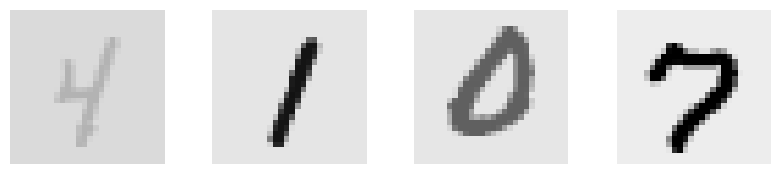

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2))

for i in range(4):
    axs[i].imshow(imgs[i], cmap='binary', vmin=0, vmax=1)
    axs[i].axis("off")

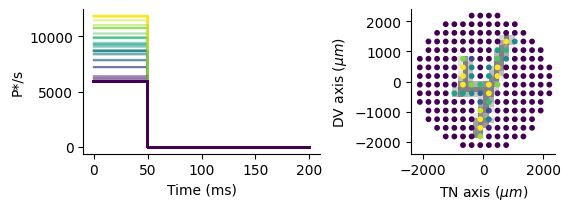

In [46]:
# Plot to confirm that the stimulus is correct
time = np.arange(0, stim_config["t_max"], stim_config["dt"])
fig, axs = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)

# Determine the colors
peak_time = np.average([stim_config["peak_start"], stim_config["peak_end"]])
intensities = stim[:, int(peak_time/stim_config["dt"])]
intensities_rescaled = (intensities - np.min(intensities))/(np.max(intensities) - np.min(intensities))
colors = plt.cm.viridis(intensities_rescaled)

for i in range(stim.shape[0]):
    axs[0].plot(time, stim[i, :], c=colors[i], alpha=0.5)
axs[0].set_ylabel("P*/s")
axs[0].set_xlabel("Time (ms)")

# Where you want the image to appear on the scatter plot [left, right, bottom, top] in scatter plot coordinates
desired_extent = [-2400, 2400, -2400, 2400]
# Create an image artist and add it to the plot with transparency
img_artist = axs[1].imshow(
    imgs[0, :, :, 0], extent=desired_extent, alpha=0.5, aspect='auto', zorder=0, cmap='binary', origin='upper'
    )  # zorder=0 puts it behind the scatter

axs[1].scatter(coords[0], coords[1], c=intensities_rescaled, cmap='viridis', s=10)
axs[1].set_aspect('equal')
axs[1].set_xlabel(r'TN axis $(\mu m)$')
axs[1].set_ylabel(r'DV axis $(\mu m)$')
sns.despine()

In [49]:
# Load trained params
with open('../../params/mnist/trained_params.pkl', 'rb') as f:
    trained_params = pickle.load(f)

In [48]:
# Simulate